<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project: Harmony
## 3.1 Matching Input Photo to Products
> Authors: Eugene Matthew Cheong
---

## Table of Contents ##

#### 1. Web Scraping

- [1.1 Scraping Lian Seng Hin Website](1.1_web_scraping_liansenghin.ipynb)
- [1.2 Scraping Hafary Website](1.2_web_scraping_hafary.ipynb)
- [1.3 Scraping Lamitak Website](1.3_web_scraping_lamitak.ipynb)
- [1.4 Scraping Nippon Website](1.4_web_scraping_nippon.ipynb)
- [1.5 Consolidate All Product Database](1.5_consolidate_product_database.ipynb)

#### 2. Preprocessing

- [2.1 Processing Canva Palettes](2.1_processing_canva_palette.ipynb)

#### 3. Modelling

- [3.1 Matching Input Photo to Products](3.1_matching_input_photo_to_products.ipynb)
- [3.2 Recommending Canva Palette to Products](3.2_recommending_canva_palette_to_product.ipynb)
- [3.3 Recommending Colours and Colour Palettes with Llama3](3.3_recommending_colours_and_colour_palettes_with_llama3.ipynb)

---

# Import Modules

In [1]:
import os
import time
import h5py

from skimage.io import imread
from skimage.transform import resize
from skimage.color import gray2rgb
from skimage.color import rgb2lab, lab2rgb, rgb2hsv, hsv2rgb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from scipy.spatial.distance import euclidean, cosine, cityblock
from sklearn.metrics.pairwise import cosine_similarity

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Model

In [2]:
def load_from_hdf5(filename):
    with h5py.File(filename, 'r') as f:
        # Initialize containers for images and flattened data
        images = []
        flattened_data = []

        # Iterate over items in HDF5 file and load them
        for i in range(len(f.keys()) // 2):  # Assuming each image has two corresponding keys (image and flat)
            img_key = f'image_{i}'
            flat_key = f'flat_{i}'
            
            # Load and append to respective lists
            images.append(np.array(f[img_key]))  # Convert to numpy array if necessary
            flattened_data.append(np.array(f[flat_key]))

    return images, flattened_data

In [3]:
data_folder = "../datasets/"

In [4]:
all_products_df = pd.read_csv('../datasets/all_products_df.csv')
image_folder = '../datasets/images/all_images'

In [5]:
all_products_df

,Model Name,Company,Type,Origin Country,Application,Filename
0,For Treccia F,Hafary,Tiles,Italy,"Wall, Floor",for-treccia-f_r-500-500-60-user-data-collectio...
1,ST26996N(M),Hafary,Tiles,Malaysia,"Floor, Wall",st26996n(m)_r-500-500-60-user-data-collections...
2,ST26996N(M),Hafary,Tiles,Malaysia,"Floor, Wall",st26996n(m)_r-500-500-60-user-data-collections...
3,QSY8003A,Hafary,Tiles,China,"Floor, Wall",qsy8003a_r-500-500-60-user-data-collections-40...
4,QSY8017A,Hafary,Tiles,China,"Floor, Wall",qsy8017a_r-500-500-60-user-data-collections-40...
...,...,...,...,...,...,...
12414,Cumulus Clouds,Nippon,Paint,Singapore,Wall,NP N 3313 P.png
12415,Hail Rain,Nippon,Paint,Singapore,Wall,NP N 3314 P.png
12416,Painted Glass,Nippon,Paint,Singapore,Wall,NP N 3315 P.png
12417,Blue Pool,Nippon,Paint,Singapore,Wall,NP N 1972 P.png


# Matching given photo to products in the catalogue

### Approach: 

To filter the product catalog, we will employ two methods. 
Initially, we will identify products that are closest in color to the input image by calculating the spatial distances between the color features of the input image and those of the products in the catalog, which have been pre-processed and stored in an h5 file. Subsequently, we will use a pre-trained model to generate spatial feature maps of the products initially sorted by color similarity. We will then compute the spatial distances between these feature maps to further refine our sorting based on the similarity in features, resulting in a re-sorted list of products that closely match the input image in both color and texture characteristics.

## Input test image

In [6]:
new_image_path = '../test_images/IMG_6785.JPG'

### Why CIELAB instead of RGB??

- CIELAB encompasses the range of human color perception. Through color measurements, CIELAB color space distinguishes color differences with precise accuracy using three color values.
- CIELAB and Vision: CIELAB attempts to approximate human vision, making it a better choice for applications that require a naturalistic assessment of color differences. The components of CIELAB (L for lightness, a for the position between magenta and green, and b for the position between yellow and blue) are more directly aligned with the way humans perceive colors.

[What Is CIELAB?]("https://www.datacolor.com/business-solutions/blog/what-is-cielab/#:~:text=CIELAB%20encompasses%20the%20range%20of,color%20on%20a%20consistent%20basis.")

In [7]:
# Function to preprocess and flatten images
def preprocess(image_path):
    img = imread(image_path)
    if  img.shape[2] == 4:  # Check if the image has an alpha channel
        img = img[:, :, :3]  # Remove the alpha channel if present

    # Convert the RGB image to Lab color space
    #img_lab = rgb2hsv(img)
    img_lab = rgb2lab(img)

    # Resize the image to a fixed size (e.g., 256x256)
    img_resized = resize(img_lab, (256, 256), anti_aliasing=True)
    
    # Optionally, you can flatten the image if needed for further processing
    img_flattened = img_resized.flatten()

    # Return both the resized Lab image and the flattened version
    return img_resized, img_flattened

# Testing out the 3 different ways of calculating Spatial Distances. Cosine, Euclidean and Cityblock a.k.a Manhattan

To calculate the cosine similarity between two vectors u and v in a way that avoids errors or undefined behavior when one or both vectors are zero vectors.

In [8]:
def safe_cosine(u, v):
    if np.linalg.norm(u) == 0 or np.linalg.norm(v) == 0:
        return 1.0  # Use 1.0 to indicate maximum dissimilarity or undefined similarity
    else:
        return cosine(u, v)

In [9]:
def safe_euclidean(u, v):
    if np.linalg.norm(u) == 0 or np.linalg.norm(v) == 0:
        return 1.0  # Use 1.0 to indicate maximum dissimilarity or undefined similarity
    else:
        return euclidean(u, v)

In [10]:
def safe_cityblock(u, v):
    if np.linalg.norm(u) == 0 or np.linalg.norm(v) == 0:
        return 1.0  # Use 1.0 to indicate maximum dissimilarity or undefined similarity
    else:
        return cityblock(u, v)

In [11]:
image_list = []

for i in list(all_products_df['Filename']):
  full_image_filepath = os.path.join(image_folder,i)
  if os.path.exists(full_image_filepath):
    image_list.append(os.path.join(image_folder,i))
  else:
    print(f"Error finding image path: {full_image_filepath}")

## Loading "preprocessed_all_images.h5

In [12]:
filename = os.path.join(data_folder,'h5','preprocessed_all_images.h5')
loaded_images, loaded_flattened_data = load_from_hdf5(filename)
processed_images = list(zip(loaded_images, loaded_flattened_data))

## Testing to find products in the catalogue with similar colour as the product in the given photo with 3 different methods.
### Cosine, Euclidean and Cityblock

In [13]:
# Separate the images for display and calculation
display_images, flat_images = zip(*processed_images)


# Add and process the new input image
new_display_image, new_flat_image = preprocess(new_image_path)

# Assuming 'new_flat_image' is a flat vector of the new image
# and 'flat_images' is a list of flat vectors of existing images
#Calculating distances with cosine
distances_cosine = [safe_cosine(new_flat_image, img) for img in flat_images]
# Sort images by similarity
cosine_sorted_indices = np.argsort(distances_cosine)[:50]  # Get indices of sorted distances

# Assuming 'new_flat_image' is a flat vector of the new image
# and 'flat_images' is a list of flat vectors of existing images
#Calculating distances with euclidean
distances_euclidean = [safe_euclidean(new_flat_image, img) for img in flat_images]
# Sort images by similarity
euclidean_sorted_indices = np.argsort(distances_euclidean)[:50]  # Get indices of sorted distances


# Assuming 'new_flat_image' is a flat vector of the new image
# and 'flat_images' is a list of flat vectors of existing images
#Calculating distances with cityblock
distances_cityblock = [safe_cityblock(new_flat_image, img) for img in flat_images]
# Sort images by similarity
cityblock_sorted_indices = np.argsort(distances_cityblock)[:50]  # Get indices of sorted distances

### Function to return the 'Model Name'

In [14]:
def get_model_name_by_filename(filename):
    # Query the DataFrame for rows where 'Filename' matches the given filename
    filtered_df = all_products_df[all_products_df['Filename'] == filename]
    
    # Check if the result is not empty
    if not filtered_df.empty:
        # Return the first 'Model Name' from the filtered DataFrame
        return filtered_df['Model Name'].iloc[0]
    else:
        # Return a message if no matching filename is found
        return "Filename not found"

In [15]:
# Display filenames of the sorted cosine images
sorted_filenames_cosine = [image_list[index] for index in cosine_sorted_indices]

# Display filenames of the sorted euclidean images
sorted_filenames_euclidean = [image_list[euclidean_index] for euclidean_index in euclidean_sorted_indices]

# Display filenames of the sorted cityblock images
sorted_filenames_cityblock = [image_list[cityblock_index] for cityblock_index in cityblock_sorted_indices]

### Results using Cosine

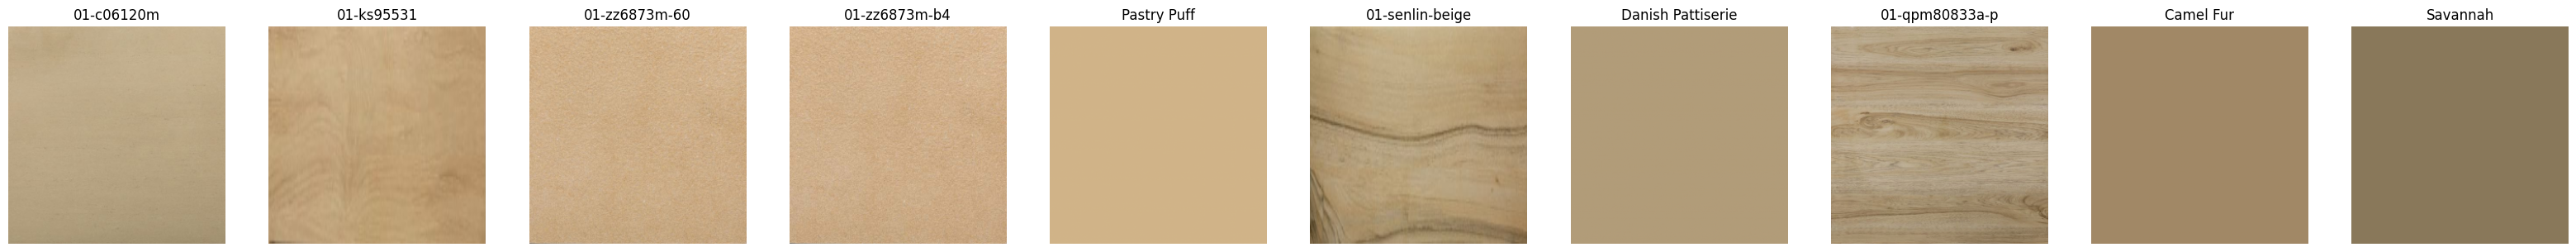

In [16]:
# Display only the top 5 images sorted by similarity
fig, axs = plt.subplots(1, 10, figsize=(40, 40))  # Adjust figure size and number of subplots to 10
for i, ax in enumerate(axs):
    ax.imshow(lab2rgb(display_images[cosine_sorted_indices[i]]))
    ax.set_title(get_model_name_by_filename(os.path.basename(sorted_filenames_cosine[i])))
    ax.axis('off')
plt.show()

### Results using Euclidean

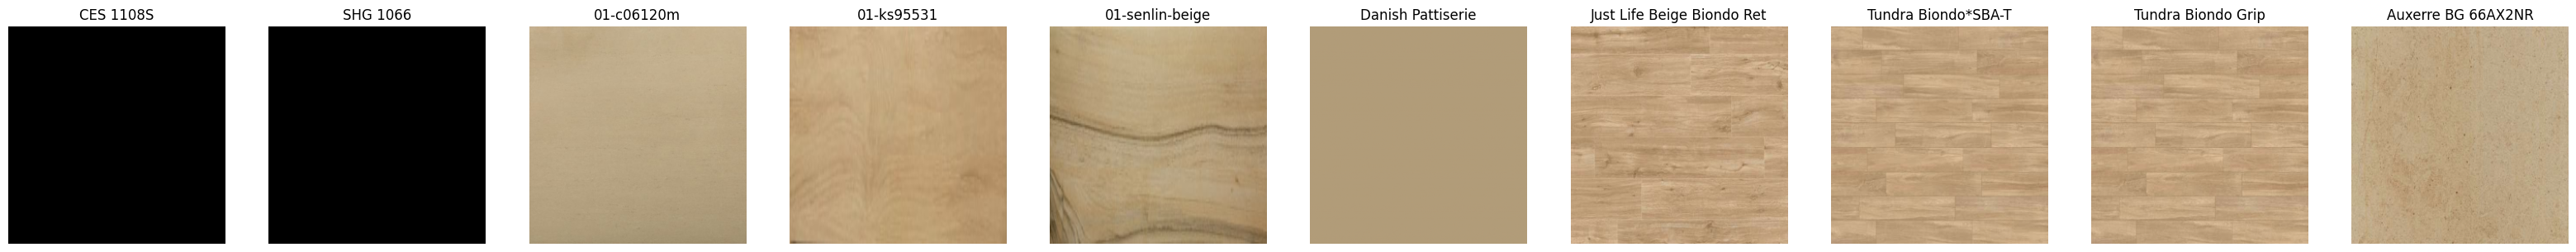

In [17]:
# Display only the top 5 images sorted by similarity
fig, axs = plt.subplots(1, 10, figsize=(40, 40))  # Adjust figure size and number of subplots to 10
for i, ax in enumerate(axs):
    ax.imshow(lab2rgb(display_images[euclidean_sorted_indices[i]]))
    ax.set_title(get_model_name_by_filename(os.path.basename(sorted_filenames_euclidean[i])))
    ax.axis('off')
plt.show()

Results are show black coloured products as the first 2 recommendation. Likely the distances between the Input photo colour values and the 2 products are the closest. This is probably one of effects of 'curse of dimenionality', where the increase in dimensions can make distance measures less effective.

### Results using Cityblock

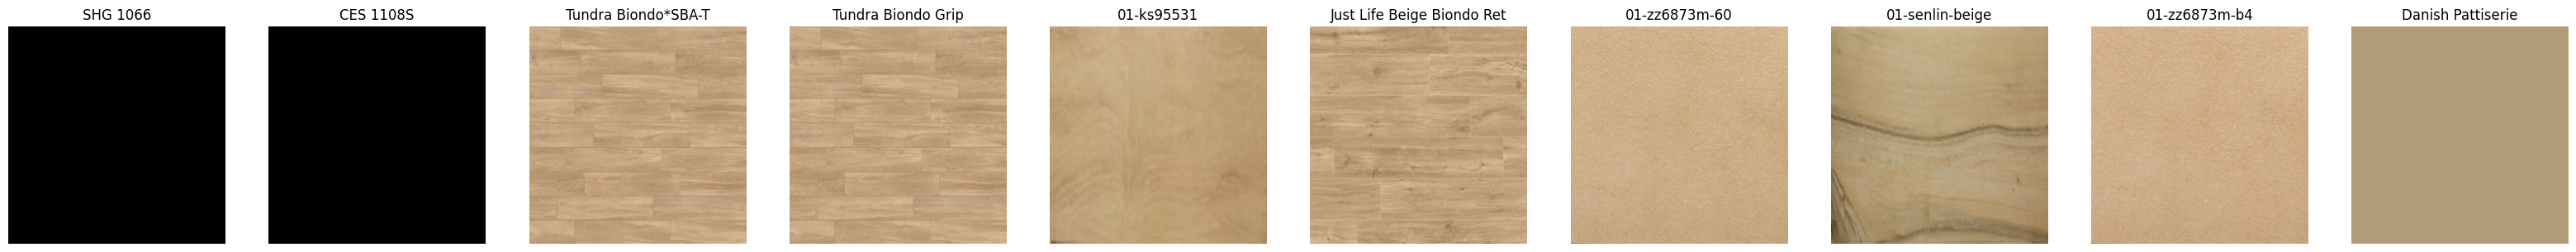

In [18]:
# Display only the top 5 images sorted by similarity
fig, axs = plt.subplots(1, 10, figsize=(40, 40))  # Adjust figure size and number of subplots to 10
for i, ax in enumerate(axs):
    ax.imshow(lab2rgb(display_images[cityblock_sorted_indices[i]]))
    ax.set_title(get_model_name_by_filename(os.path.basename(sorted_filenames_cityblock[i])))
    ax.axis('off')
plt.show()

### Why use Cosine for finding similar colours?

 - Cosine similarity measures the cosine of the angle between two vectors, making it sensitive only to the direction of the vectors, not their magnitude. This characteristic is particularly useful in color comparison because it focuses on the proportion of colors (i.e., their hue and saturation) rather than the intensity. For example, a very light pink and a very dark red might be very different in RGB space due to their different luminance levels, but their underlying hue is similar, which cosine similarity can capture more effectively.

 - Colors in images, especially when considered in a high-dimensional space (like RGB or LAB color spaces), can lead to situations where Euclidean distance becomes less intuitive. This is partly due to the "curse of dimensionality," where the increase in dimensions can make distance measures less effective. Cosine similarity, focusing only on direction, is less affected by this issue.


 - Euclidean Distance computes the straight-line distance between two points in multi-dimensional space. When used for color comparison, it can overemphasize differences in intensity and brightness rather than hue and saturation. Colors with similar visual perception but different intensities might appear quite distant in Euclidean space.

 - City Block a.k.a Manhattan Distance measures the sum of the absolute differences of their Cartesian coordinates. This method can be very sensitive to small changes in any dimension, making it less suitable for color comparison where hue and saturation are often more critical than exact precision in intensity.


## Finding Unique Features with VGG16

### VGG16

- VGG16: This is a convolutional neural network model originally designed for image classification tasks. It was proposed by Visual Geometry Group (VGG) at Oxford University and has become popular due to its simplicity and strong performance on various image recognition benchmarks.

- weights='imagenet': This parameter specifies that the model should be loaded with weights that were trained on the ImageNet dataset, a large dataset of over 14 million images belonging to 1000 classes. These pre-trained weights enable the model to effectively extract features from images, as it has already learned rich representations for a wide range of images.

- include_top=False: The VGG16 model, by default, includes a top layer of fully connected layers for the purpose of classifying ImageNet's 1000 classes. By setting include_top=False, these layers are not included, and you only get the convolutional base of the model. This is useful when you want to use the model for feature extraction in different tasks or datasets, or when you want to add custom layers tailored for a specific problem.

In [19]:
# Load a pre-trained VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.output)

2024-05-10 12:00:53.469619: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-05-10 12:00:53.469873: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-05-10 12:00:53.469895: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-05-10 12:00:53.470317: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-10 12:00:53.470343: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Using VGG16 to turn each product found into a feature that VGG16 sees. Using that we can use the flattened feature vector to compare with the input image, which is also converted into a flattened feature vector, and find the closest similarity.

In [20]:
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array) #Passes the preprocessed image array through the model and retrieves the output, which are the deep features extracted by the VGG16 architecture.
    print(features)
    return img, features.flatten()

In [21]:
# Example: Extract features from an image
processed_images_features = [extract_features(img_path) for img_path in sorted_filenames_cosine]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.33354408
    0.        ]
   [0.         0.         0.         ... 0.         2.6609485
    0.        ]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         2.7253296
    0.        ]]

  [[0.         0.         0.         ... 0.         0.
    0.        

2024-05-10 12:00:54.101285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


[[[[0.        0.        0.        ... 0.        0.        0.       ]
   [0.        0.        0.        ... 0.        0.        0.       ]
   [0.        0.        0.        ... 0.        0.        0.       ]
   ...
   [0.        0.        0.        ... 0.        0.        0.       ]
   [0.        0.        0.        ... 0.        0.        0.       ]
   [0.        0.        0.        ... 0.        0.        0.       ]]

  [[0.        0.        0.        ... 0.        0.        0.       ]
   [0.        0.        0.        ... 0.        0.        0.       ]
   [0.        0.        0.        ... 0.        0.        0.       ]
   ...
   [0.        0.        0.        ... 0.        0.        0.       ]
   [0.        0.        0.        ... 0.        0.        0.       ]
   [0.        0.        0.        ... 0.        0.        0.       ]]

  [[0.        0.        0.        ... 0.        0.        0.       ]
   [0.        0.        0.        ... 0.        0.        0.       ]
   [0.        0.

### Testing again using the 3 methods of calculating spatial distances

In [22]:
# Separate the images for display and calculation
display_images, flat_images = zip(*processed_images_features)


# Add and process the new input image
new_display_image, new_flat_image = extract_features(new_image_path)

# Assuming 'new_flat_image' is a flat vector of the new image
# and 'flat_images' is a list of flat vectors of existing images
#Calculating distances with cosine
distances_cosine = [safe_cosine(new_flat_image, img) for img in flat_images]
# Sort images by similarity
cosine_sorted_indices = np.argsort(distances_cosine)  # Get indices of sorted distances

# Assuming 'new_flat_image' is a flat vector of the new image
# and 'flat_images' is a list of flat vectors of existing images
#Calculating distances with euclidean
distances_euclidean = [safe_euclidean(new_flat_image, img) for img in flat_images]
# Sort images by similarity
euclidean_sorted_indices = np.argsort(distances_euclidean) # Get indices of sorted distances


# Assuming 'new_flat_image' is a flat vector of the new image
# and 'flat_images' is a list of flat vectors of existing images
#Calculating distances with cityblock
distances_cityblock = [safe_cityblock(new_flat_image, img) for img in flat_images]
# Sort images by similarity
cityblock_sorted_indices = np.argsort(distances_cityblock)  # Get indices of sorted distances


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  ...

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. 

# Final Results

In [23]:
# Display filenames of the sorted cosine images
sorted_filenames_feature_cosine = [image_list[index] for index in cosine_sorted_indices]

# Display filenames of the sorted euclidean images
sorted_filenames_feature_euclidean = [image_list[index] for index in euclidean_sorted_indices]

# Display filenames of the sorted cityblock images
sorted_filenames_feature_cityblock = [image_list[index] for index in cityblock_sorted_indices]

### Results using Cosine

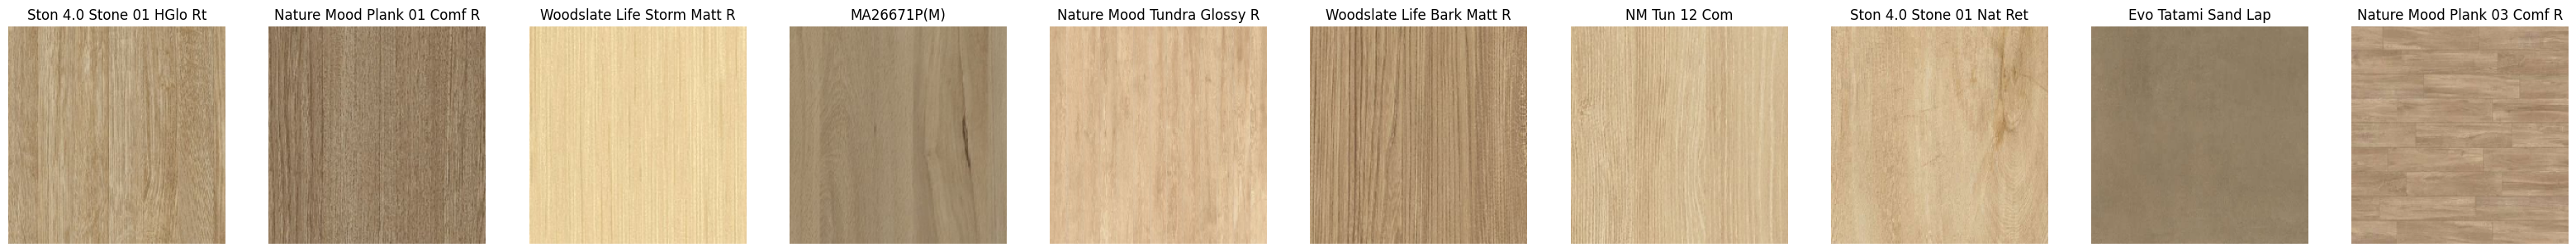

In [24]:
# Display only the top 5 images sorted by similarity
fig, axs = plt.subplots(1, 10, figsize=(40, 40))  # Adjust figure size and number of subplots to 10
for i, ax in enumerate(axs):
    ax.imshow(display_images[cosine_sorted_indices[i]])
    ax.set_title(get_model_name_by_filename(os.path.basename(sorted_filenames_feature_cosine[i])))
    ax.axis('off')
plt.show()

### Results using Euclidean

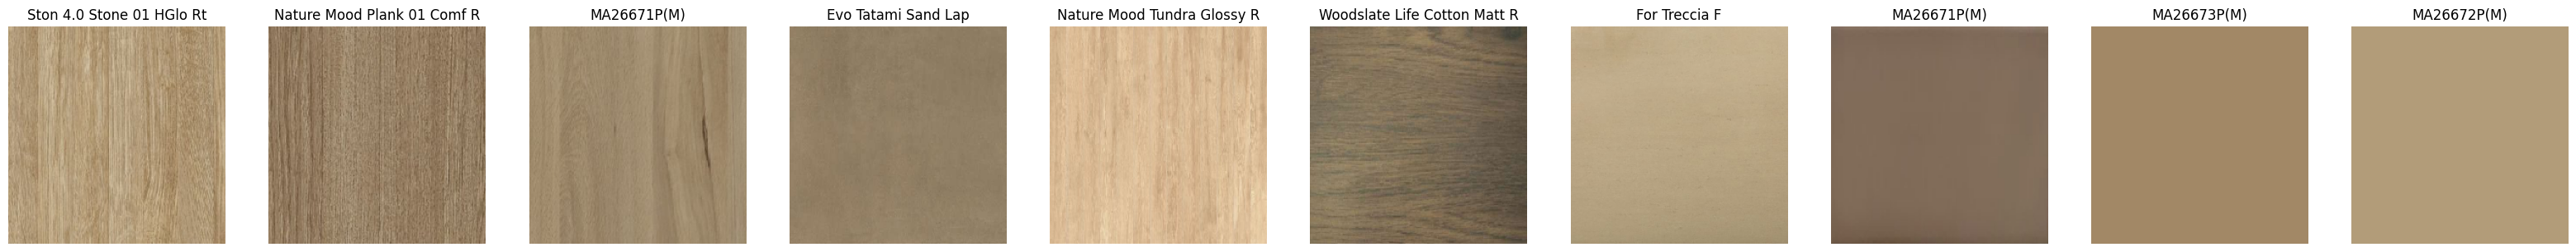

In [25]:
# Display only the top 5 images sorted by similarity
fig, axs = plt.subplots(1, 10, figsize=(40, 40))  # Adjust figure size and number of subplots to 10
for i, ax in enumerate(axs):
    ax.imshow(display_images[euclidean_sorted_indices[i]])
    ax.set_title(get_model_name_by_filename(os.path.basename(sorted_filenames_feature_euclidean[i])))
    ax.axis('off')
plt.show()

### Results using Cityblock

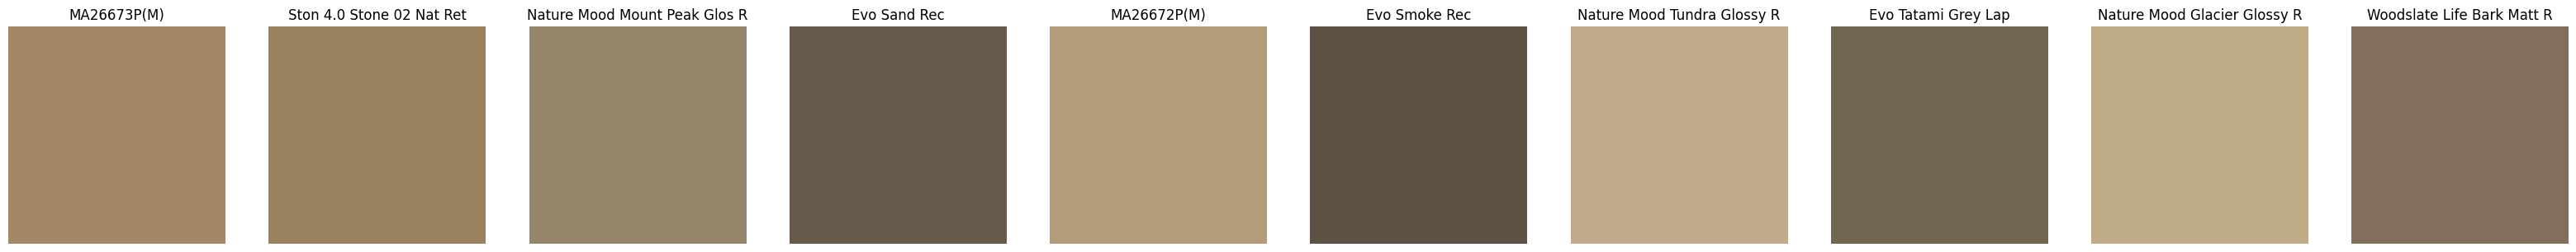

In [26]:
# Display only the top 5 images sorted by similarity
fig, axs = plt.subplots(1, 10, figsize=(40, 40))  # Adjust figure size and number of subplots to 10
for i, ax in enumerate(axs):
    ax.imshow(display_images[cityblock_sorted_indices[i]])
    ax.set_title(get_model_name_by_filename(os.path.basename(sorted_filenames_feature_cityblock[i])))
    ax.axis('off')
plt.show()

The results from the Euclidean and cosine distances are quite similar. However, the Euclidean distance provides more consistent outcomes regarding color, albeit with some irregularities in texture. In contrast, the cosine distance results display variability in color but offer greater consistency in texture.

---

### Next Notebook: [3.2 Recommending Canva Palette to Products](3.2_recommending_canva_palette_to_product.ipynb)